In [1]:
import os
import json
import csv
import sys
import numpy as np
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from tensorflow.keras.utils import plot_model
import datetime
import time
from tensorflow.keras.callbacks import TensorBoard

2023-05-16 23:00:33.497275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
csv_path = "csv_fma_30secs_data.csv"
sr=22050
csv.field_size_limit(sys.maxsize)

131072

In [3]:
#Read MFCC data from CSV
def csv_read_data(csv_path):
    # Load data from CSV file
    with open(csv_path, 'r') as csvfile:
        reader = csv.reader(csvfile)

        # Skip the header row
        next(reader)

        # Initialize lists to hold genre and MFCC data
        genres = []
        mfcc = []

        # Iterate over each row of the CSV file
        for row in reader:
            # Extract genre and MFCC data from the row
            genre = int(row[0])
            mfcc_data = json.loads(row[1])

            # Append genre and MFCC data to lists
            genres.append(genre)
            mfcc.append(mfcc_data)

    # Convert lists to numpy arrays
    X = np.array(mfcc)
    y = np.array(genres)

    return X, y

In [4]:
def stratified_split_dataset(inputs, targets, test_split_size, val_split_size):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_split_size, random_state=42)
    
    train_val_indices, test_indices = next(sss.split(inputs, targets))
    inputs_train_val, targets_train_val = inputs[train_val_indices], targets[train_val_indices]
    
    val_size = val_split_size / (1 - test_split_size)
    sss_train = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=43)
    train_indices, val_indices = next(sss_train.split(inputs_train_val, targets_train_val))
    
    inputs_train, targets_train = inputs_train_val[train_indices], targets_train_val[train_indices]
    inputs_val, targets_val = inputs_train_val[val_indices], targets_train_val[val_indices]
    inputs_test, targets_test = inputs[test_indices], targets[test_indices]
    
    # Needed for compatibility reasons
    inputs_train = inputs_train[..., np.newaxis]
    inputs_val = inputs_val[..., np.newaxis]
    inputs_test=  inputs_test[..., np.newaxis]
    
    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test


In [5]:
#Used to plot performance history of model
def plot_performance(hist):
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [6]:
#=============== MAIN ===============
#Reading MFCC data from CSV
inputs, targets = csv_read_data(csv_path)

In [7]:
#Splitting data
Xtrain, Xval, Xtest, ytrain, yval, ytest =stratified_split_dataset(inputs, targets, 0.15, 0.15)


In [8]:
print(Xtrain.shape)
print(Xtest.shape)
print(Xval.shape)

(2433, 1249, 40, 1)
(522, 1249, 40, 1)
(522, 1249, 40, 1)


In [9]:
#Design the model
def design_model(input_shape):
    
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])
    
    return model

In [10]:
#Model Creation
input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
model = design_model(input_shape)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])

2023-05-16 23:02:25.675466: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22077 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c1:00.0, compute capability: 8.9


In [11]:
#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1247, 38, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 624, 19, 64)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 624, 19, 64)      256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 622, 17, 64)       36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 311, 9, 64)       0         
 2D)                                                             
                                                        

In [12]:
#TENSORBOARD
NAME= "MFCC 30secs Model"
log_dir = "logs/fit/" + NAME
tensorboard_callback = [tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)] 


In [13]:
#COMPILATION
history = model.fit(Xtrain, ytrain,
                   validation_data = (Xval, yval),
                   epochs = 550,
                   batch_size = 64,
                   callbacks=[tensorboard_callback])

model.save("./Models/"+NAME)

Epoch 1/550


2023-05-16 23:02:27.348042: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-16 23:02:28.246597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-16 23:02:28.922474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-16 23:02:28.924208: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fe332cdc190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-16 23:02:28.924226: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-05-16 23:02:28.927888: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_uti

39/39 [==============================] - 7s 46ms/step - loss: 1.8906 - acc: 0.3395 - val_loss: 1.7979 - val_acc: 0.3027
Epoch 2/550
39/39 [==============================] - 1s 33ms/step - loss: 1.3959 - acc: 0.4842 - val_loss: 1.5364 - val_acc: 0.4176
Epoch 3/550
39/39 [==============================] - 1s 33ms/step - loss: 1.2586 - acc: 0.5356 - val_loss: 1.3962 - val_acc: 0.4617
Epoch 4/550
39/39 [==============================] - 1s 33ms/step - loss: 1.1644 - acc: 0.5635 - val_loss: 1.2173 - val_acc: 0.5709
Epoch 5/550
39/39 [==============================] - 1s 33ms/step - loss: 1.1470 - acc: 0.5738 - val_loss: 1.1724 - val_acc: 0.5881
Epoch 6/550
39/39 [==============================] - 1s 33ms/step - loss: 1.1050 - acc: 0.5968 - val_loss: 1.0998 - val_acc: 0.6092
Epoch 7/550
39/39 [==============================] - 1s 33ms/step - loss: 1.0679 - acc: 0.6132 - val_loss: 1.0954 - val_acc: 0.6015
Epoch 8/550
39/39 [==============================] - 1s 33ms/step - loss: 1.0535 - acc: 

2023-05-16 23:03:10.719986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,155,4,64]
	 [[{{node inputs}}]]
2023-05-16 23:03:10.732046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,77,1,64]
	 [[{{node inputs}}]]
2023-05-16 23:03:11.179190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,155,4,64]
	 [[{{node inputs}}]]
20

INFO:tensorflow:Assets written to: ./Models/MFCC 30secs Model/assets


INFO:tensorflow:Assets written to: ./Models/MFCC 30secs Model/assets


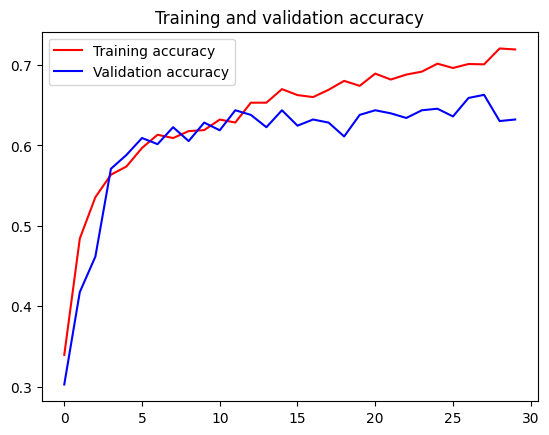

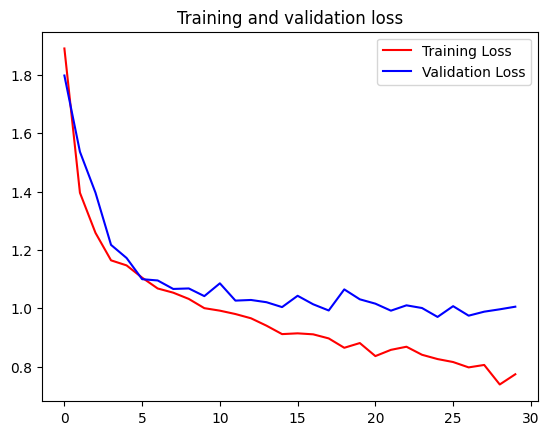

In [14]:
#Plot Performance
plot_performance(history)

In [15]:
y_pred = model.predict(Xtest)

17/17 [==============================] - 0s 5ms/step


In [16]:
from sklearn.metrics import accuracy_score

y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the accuracy
accuracy = accuracy_score(ytest, y_pred_classes)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.6494


In [17]:
from sklearn.metrics import f1_score

# Make predictions on the test set
y_pred_test = model.predict(Xtest)

# Convert probabilities to class labels
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

# Compute the F1 score
f1_test = f1_score(ytest, y_pred_test_labels, average='micro')

print('Test F1 score: ', f1_test)

17/17 [==============================] - 0s 5ms/step
Test F1 score:  0.6494252873563219
